In [4]:
#import essential libraries
import pandas as pd
import numpy as np

In [5]:
gst_data = pd.read_csv('/Users/vritti/dataset/X_Train_Data_Input.csv')
gst_target=pd.read_csv('/Users/vritti/dataset/Y_Train_Data_Target.csv')
predict_X=pd.read_csv('/Users/vritti/dataset/X_Test_Data_Input.csv')
predict_Y=pd.read_csv('/Users/vritti/dataset/Y_Test_Data_Target.csv')

# Exploring the dataset

In [6]:
print(gst_data.head())
print(gst_target.head())

                                 ID  Column0  Column1  Column2   Column3  \
0  ad1a67e4cbddc767a3456b0d94299b9e      2.0     2495   3726.0  0.678139   
1  7246d2f76ac0c217ec25e72ea5f014cb      0.0     2495   3454.0  0.452580   
2  22ba388e7dd14c13342c49e75fc29dda      2.0     2495   4543.0 -1.577453   
3  59f9b981472d97342587fb3e6392aeb1      0.0      211     59.0       NaN   
4  f6317cf7ecf126859804eddff279aead      0.0      718    950.0 -2.028572   

    Column4   Column5   Column6   Column7   Column8  ...  Column12  Column13  \
0  0.701403 -0.007468  0.434190 -0.015603  0.606265  ...         0         0   
1  0.701403 -0.007468  1.554998 -0.015574  0.329946  ...         0         0   
2 -1.429540 -0.007469 -0.407939 -0.015607 -0.774979  ...         1         1   
3       NaN       NaN -0.407939 -0.015607 -0.774979  ...         0         0   
4 -1.855728       NaN -0.407939 -0.015607 -0.774979  ...         0         0   

   Column14  Column15  Column16  Column17  Column18  Column19 

In [7]:
print(gst_data.shape)
print(predict_X.shape)

(785133, 23)
(261712, 23)


In [8]:
gst_data.isnull().sum()

ID               0
Column0          9
Column1          0
Column2          0
Column3     126303
Column4     127710
Column5     167180
Column6       3850
Column7          0
Column8       3850
Column9     732137
Column10         0
Column11         0
Column12         0
Column13         0
Column14    365703
Column15     16456
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
dtype: int64

In [9]:
print(predict_X.isnull().sum())

ID               0
Column0          2
Column1          0
Column2          0
Column3      42234
Column4      42710
Column5      55659
Column6       1234
Column7          0
Column8       1234
Column9     243853
Column10         0
Column11         0
Column12         0
Column13         0
Column14    121679
Column15      5485
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
dtype: int64


# Data Cleaning 

In [10]:
gst_data=gst_data.drop('Column9',axis=1) #to drop column 9 because of many missing values
predict_X=predict_X.drop('Column9',axis=1)

In [11]:
print(gst_data.columns)
print(predict_X.columns)

Index(['ID', 'Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12',
       'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18',
       'Column19', 'Column20', 'Column21'],
      dtype='object')
Index(['ID', 'Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12',
       'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18',
       'Column19', 'Column20', 'Column21'],
      dtype='object')


In [12]:
#for train sheet
gst_data.replace('NA',np.nan,inplace=True)
gst_data = gst_data.apply(pd.to_numeric, errors='coerce')
#for test sheet
predict_X.replace('NA',np.nan,inplace=True)
predict_X=predict_X.apply(pd.to_numeric,errors='coerce')

In [13]:
print(gst_data.shape)
print(predict_X.shape)

(785133, 22)
(261712, 22)


# Data Preprocessing

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent', 'constant'
#train data
gst_data = pd.DataFrame(imputer.fit_transform(gst_data), columns=gst_data.columns)
#test data
predict_X = pd.DataFrame(imputer.transform(predict_X), columns=predict_X.columns) 
#imputer removes columns with null values by default;only transorm ensure same rules as for training data 
#replacing NA values with mean

In [15]:
from sklearn.preprocessing import StandardScaler
#train data
scaler=StandardScaler()
non_numeric_columns=gst_data.select_dtypes(include=['object']).columns
gst_data=pd.DataFrame(scaler.fit_transform(gst_data),columns=gst_data.columns)
#test data
non_numeric_columns_predict=predict_X.select_dtypes(include=['object']).columns
predict_X=pd.DataFrame(scaler.fit_transform(predict_X),columns=predict_X.columns)

#### Dimension Reduction

In [16]:
#initially applied pca
from sklearn.decomposition import PCA

# Determine the number of PCA components to retain (e.g., 95% variance)
pca = PCA(n_components=0.95, random_state=42)
gst_pca = pca.fit_transform(gst_data)
predict_X_pca = pca.fit_transform(predict_X)

print(f"PCA reduced the dataset from {gst_data.shape[1]} to {gst_pca.shape[1]} dimensions.")
print(f"Total Explained Variance by PCA: {pca.explained_variance_ratio_.sum() * 100:.2f}%")



PCA reduced the dataset from 22 to 17 dimensions.
Total Explained Variance by PCA: 96.80%


#### Data splitting

In [17]:
from sklearn.model_selection import train_test_split
X=gst_pca
y=gst_target['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Model Building

In [40]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='error',objective='binary:logistic',booster='dart',eta=0.4)
# Train the model
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [36]:
#xgboost report
y_pred = xgb_model.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

Accuracy: 0.9797359689734887
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    142275
           1       0.86      0.94      0.90     14752

    accuracy                           0.98    157027
   macro avg       0.92      0.96      0.94    157027
weighted avg       0.98      0.98      0.98    157027



Confusion Matrix:
[[139920   2355]
 [   827  13925]]


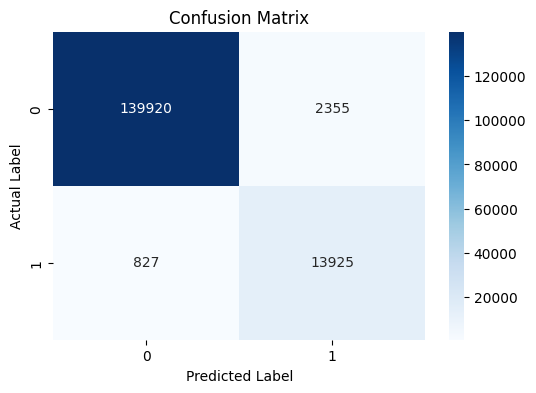

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

AUC-ROC: 0.9953047594176747


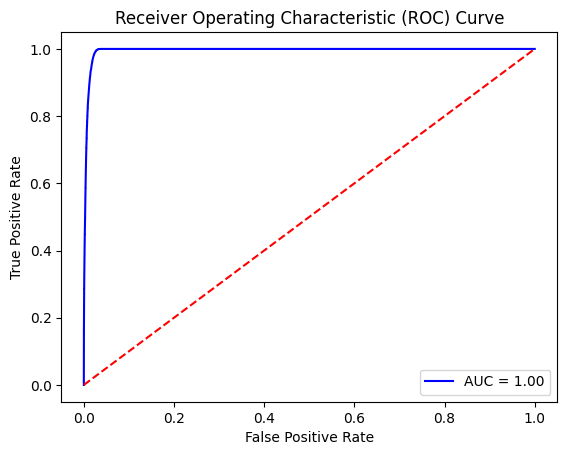

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {auc}')
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Prediction Report for training test

Accuracy: 0.9619734670171792
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    237034
           1       0.81      0.78      0.79     24678

    accuracy                           0.96    261712
   macro avg       0.89      0.88      0.89    261712
weighted avg       0.96      0.96      0.96    261712

AUC-ROC with XGBoost: 0.9880
AUC-ROC: 0.987998432543511


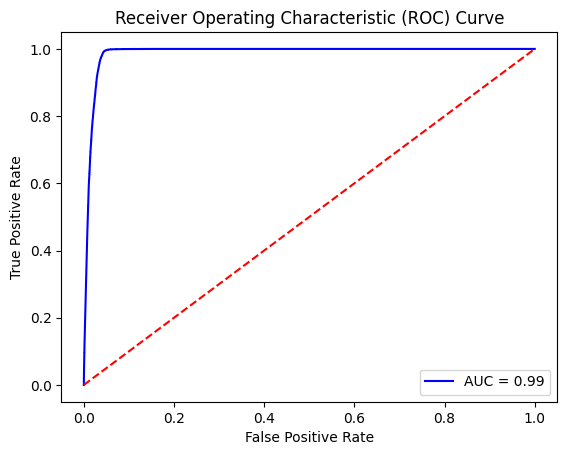

In [39]:
Y_pred = xgb_model.predict_proba(predict_X_pca)[:, 1]

Y_pred_class = (Y_pred > 0.5).astype(int)
print("Accuracy:", accuracy_score(predict_Y['target'], Y_pred_class))

print(classification_report(predict_Y['target'], Y_pred_class))
auc_xgb1 = roc_auc_score(predict_Y['target'], Y_pred)
print(f'AUC-ROC with XGBoost: {auc_xgb1:.4f}')

auc = roc_auc_score(predict_Y['target'], Y_pred)
print(f'AUC-ROC: {auc}')
fpr, tpr, thresholds = roc_curve(predict_Y['target'], Y_pred)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[231732   5302]
 [  3276  21402]]


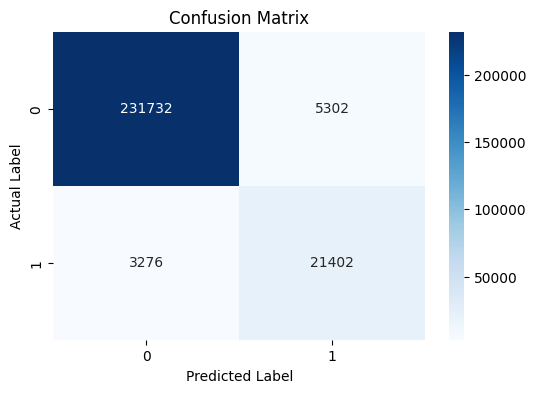

In [34]:
conf_matrix = confusion_matrix(predict_Y['target'], Y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()